In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import EuroSAT
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import time
import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()


Total dataset size: 27000
Train size: 21600, Test size: 5400
Available labels: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


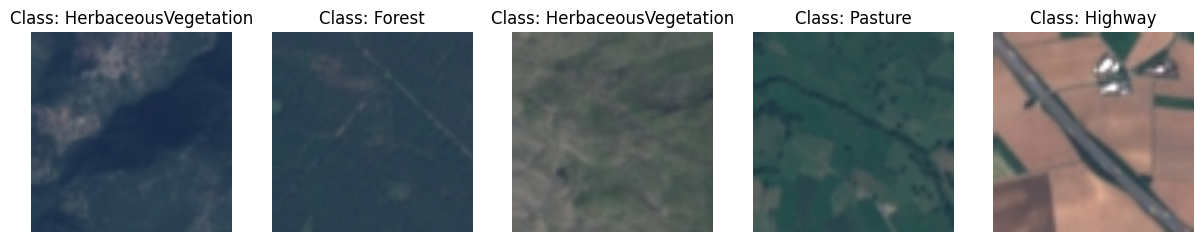

In [2]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # match ResNet input size
    transforms.ToTensor(),
])

# Load dataset
dataset = EuroSAT(root="./data", transform=transform, download=True)

# Dataset split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

# Show available labels
print(f"Available labels: {dataset.classes}")

# Show some images
# Show example images
def show_images(dataset, n=5):
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[i]
        axs[i].imshow(img.permute(1, 2, 0))
        axs[i].set_title(f"Class: {dataset.dataset.classes[label]}")
        axs[i].axis("off")
    plt.show()
show_images(train_dataset, n=5)


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNNWithBatchNorm(nn.Module):
    def __init__(self, num_classes):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            del images, labels, outputs, loss
            torch.cuda.empty_cache()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Evaluate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    end_time = time.time()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Training time: {end_time - start_time:.2f} seconds")
    return accuracy, end_time - start_time


In [5]:
from torchvision.models import resnet18

def get_resnet_model(num_classes, finetune=False):
    model = resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = finetune
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [6]:
from torchvision.models import efficientnet_b5

def get_efficientnet_model(num_classes, finetune=False):
    model = efficientnet_b5(pretrained=True)
    for param in model.parameters():
        param.requires_grad = finetune
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


In [7]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
num_classes = len(dataset.classes)
results = {}

print("\n🔧 Training CNN from scratch:")
cnn_model = CNNWithBatchNorm(num_classes=num_classes)
acc, t = train_model(cnn_model, train_loader, test_loader)
results["CNN Scratch"] = (acc, t)    



🔧 Training CNN from scratch:
Epoch 1/5, Loss: 2.1108
Epoch 2/5, Loss: 1.1025
Epoch 3/5, Loss: 0.9094
Epoch 4/5, Loss: 0.7700
Epoch 5/5, Loss: 0.6725
Test Accuracy: 73.31%
Training time: 615.64 seconds


In [8]:
print("\n🧠 ResNet18 as feature extractor:")
resnet_feat = get_resnet_model(num_classes=num_classes, finetune=False)
acc, t = train_model(resnet_feat, train_loader, test_loader)
results["ResNet18 Frozen"] = (acc, t)


🧠 ResNet18 as feature extractor:


/home/lr/.cache/pypoetry/virtualenvs/ailab-M5MNRa5y-py3.13/lib64/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lr/.cache/pypoetry/virtualenvs/ailab-M5MNRa5y-py3.13/lib64/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 0.5693
Epoch 2/5, Loss: 0.3664
Epoch 3/5, Loss: 0.3339
Epoch 4/5, Loss: 0.3152
Epoch 5/5, Loss: 0.3085
Test Accuracy: 92.35%
Training time: 202.53 seconds


In [9]:
print("\n🧠 ResNet18 fine-tuned:")
resnet_fine = get_resnet_model(num_classes=num_classes, finetune=True)
acc, t = train_model(resnet_fine, train_loader, test_loader, lr=0.0001)
results["ResNet18 Fine-tuned"] = (acc, t)



🧠 ResNet18 fine-tuned:
Epoch 1/5, Loss: 0.2473
Epoch 2/5, Loss: 0.1159
Epoch 3/5, Loss: 0.0840
Epoch 4/5, Loss: 0.0616
Epoch 5/5, Loss: 0.0503
Test Accuracy: 97.17%
Training time: 446.64 seconds


In [10]:

print("\n🚀 EfficientNet_B5 as feature extractor:")
eff_feat = get_efficientnet_model(num_classes=num_classes, finetune=False)
acc, t = train_model(eff_feat, train_loader, test_loader)
results["EfficientNet_B5 Frozen"] = (acc, t)



🚀 EfficientNet_B5 as feature extractor:


/home/lr/.cache/pypoetry/virtualenvs/ailab-M5MNRa5y-py3.13/lib64/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 0.7280
Epoch 2/5, Loss: 0.5148
Epoch 3/5, Loss: 0.4956
Epoch 4/5, Loss: 0.4717
Epoch 5/5, Loss: 0.4679
Test Accuracy: 89.26%
Training time: 713.60 seconds


In [13]:
print("\n🚀 EfficientNet_B5 fine-tuned:")
eff_fine = get_efficientnet_model(num_classes=num_classes, finetune=True)
acc, t = train_model(eff_fine, train_loader, test_loader, lr=0.0001)
results["EfficientNet_B5 Fine-tuned"] = (acc, t)



🚀 EfficientNet_B5 fine-tuned:


/home/lr/.cache/pypoetry/virtualenvs/ailab-M5MNRa5y-py3.13/lib64/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lr/.cache/pypoetry/virtualenvs/ailab-M5MNRa5y-py3.13/lib64/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 3.69 GiB of which 3.12 MiB is free. Including non-PyTorch memory, this process has 3.67 GiB memory in use. Of the allocated memory 3.49 GiB is allocated by PyTorch, and 66.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Final comparison
print("\n📊 Results Comparison:")
for k, (acc, t) in results.items():
    print(f"{k}: Accuracy = {acc:.2f}%, Time = {t:.2f}s")
